# Classical ML

## Import Required Modules

In [1]:
%load_ext autoreload
%autoreload 2

## Import System tools

In [2]:
import os
import sys
import gc
import cProfile
import warnings

In [3]:
current_dir = os.getcwd()
helpers = os.path.join(current_dir, "helpers")
sys.path.insert(0,helpers)

## Importing libraries

In [4]:
from enum import Enum, IntEnum
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as markers
import seaborn as sns
import json
import pickle
from tabulate import tabulate
from logger import logger
import directory_manager as dm
import object_manager as om
import data_structures as ds
import df_manager as dfm
from data_model import Metrics, CSVHeader,HandWashingType
from filters import band_pass_filter
from sliding_window import get_windows
import features
from tqdm import tqdm
from collections import Counter

import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler

from tsfresh.feature_extraction import extract_features

import sampler

2023-09-03 19:17:16 - INFO - Logger Created.


In [18]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours


## Load files

In [6]:
# Load lists of csv files
data_folder = "features"
personalized_subject = "03"
csv_files = dm.get_files_names(dm.get_data_dir(data_folder))
grouped_files = ds.group_by_subjects(csv_files)
subjects = [key for key in grouped_files.keys()]
print(f"Total Subjects:{len(subjects)}")

subjects.remove(personalized_subject)
total_subjects = len(subjects)
print(f"Personalized Subject:{personalized_subject}")

#random.seed(52)
random.shuffle(subjects)
print(f"Shuffled:{subjects}")
total_train = int(0.85*total_subjects)

train_sub_ids = subjects[:total_train]
test_sub_ids = list(set(subjects)-set(train_sub_ids))

print(f"Train_set:{train_sub_ids}")
print(f"Test_set:{test_sub_ids}")

Total Subjects:22
Personalized Subject:03
Shuffled:['22', '13', '07', '19', '29', '24', '21', '30', '18', '02', '20', '04', '25', '12', '05', '15', '11', '01', '09', '10', '27']
Train_set:['22', '13', '07', '19', '29', '24', '21', '30', '18', '02', '20', '04', '25', '12', '05', '15', '11']
Test_set:['09', '27', '10', '01']


In [7]:
grouped_files = ds.group_by_subjects(csv_files)

train_set = {}
test_set = {}

for sub, files in grouped_files.items():
    if sub in train_sub_ids:
        train_set[sub] = files
    else:
        test_set[sub]=files

print(f"Train Set:{len(train_set)}")
print(f"Test Set: {len(test_set)}")

Train Set:17
Test Set: 5


In [8]:
train_files = [files[0] for files in train_set.values()]
test_files = [files[0] for files in test_set.values()]

In [9]:
df_train = dfm.load_all_files(train_files, data_folder, add_sub_id=True)
df_test = dfm.load_all_files(test_files, data_folder, add_sub_id=True)

Loading CSV Files:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:16<00:00,  1.04it/s]
2023-09-03 19:18:11 - INFO - 17 csv files loaded successfully. DataFrame Length:2473264
Loading CSV Files:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]
2023-09-03 19:18:14 - INFO - 5 csv files loaded successfully. DataFrame Length:559041


In [10]:
def plot_multiple_histograms(dataframes, names, num_cols=1):
    """
    Plots multiple histograms in rows within one figure.

    Args:
        dataframes (list): List of DataFrames, each containing label data in a single column.
        names (list): List of names corresponding to each DataFrame for labeling the subplots.
    """
    num_dataframes = len(dataframes)
    
    # Determine the number of rows and columns for subplots
    num_rows = num_dataframes//num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.subplots_adjust(hspace=0.5)

    for i, df in enumerate(dataframes):
        row = i//num_cols
        col = i%num_cols
        if col>2:
            ax = axes[row,col]
        else:
            ax = axes[row]
        ax.hist(df.iloc[:, -2], bins=len(df[df.columns[-2]].unique()), rwidth=0.8, alpha=0.7, color='skyblue')
        ax.set_xlabel('Labels')
        ax.set_ylabel('Frequency')
        ax.set_title(names[i])
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
    # Remove empty subplots if any
    for i in range(num_dataframes, num_rows * num_cols):
        fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.show()

In [13]:
def plot_multiple_pies(dataframes, names, num_cols=1):
    """
    Plots multiple histograms in rows within one figure.

    Args:
        dataframes (list): List of DataFrames, each containing label data in a single column.
        names (list): List of names corresponding to each DataFrame for labeling the subplots.
    """
    num_dataframes = len(dataframes)
    
    labels = ['others', 'rHW', 'cHW']
    
    # Determine the number of rows and columns for subplots
    num_rows = num_dataframes//num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.subplots_adjust(hspace=0.5)
    
    # Colors for the pie chart
    colors = ["#47B39C", "#FFC154", "#EC6B56"]

    for i, df in enumerate(dataframes):
        other_totals = len(df[df["relabeled"]==0])
        rHW_totals = len(df[df["relabeled"]==1])
        cHW_totals = len(df[df["relabeled"]==2])
        category_counts = [other_totals, rHW_totals, cHW_totals]
        overall_percentages = [(count / len(df)) * 100 for count in category_counts]

        row = i//num_cols
        col = i%num_cols
        if num_rows==1 or num_cols ==1:
            ax = axes[i]
        else:
            ax = axes[row,col]
        
        #ax.pie(category_counts, labels=categories, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightpink'])
        #ax.axis('equal')
        wedges, _ ,_ = ax.pie(overall_percentages, colors=colors, startangle=90, autopct="",wedgeprops={'edgecolor': 'black'})

        # Create legend with values
        legend_labels = [f"{label}: {percentage:.1f}%" for label, percentage in zip(labels, overall_percentages)]
        ax.legend(wedges, legend_labels, loc="center", bbox_to_anchor=(0.5, -0.1))

        # Remove text from pie chart
        #ax.setp(wedges, width=0.4) 

        #ax.hist(category_counts, bins=categories, rwidth=0.8, alpha=0.7, color='skyblue')
        #ax.set_xlabel('Labels')
        #ax.set_ylabel('Frequency')
        ax.set_title(names[i])
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        
    # Remove empty subplots if any
    for i in range(num_dataframes, num_rows * num_cols):
        fig.delaxes(axes[i // num_cols, i % num_cols])
    
    # Show the legend
    plt.axis('off')
    plt.show()

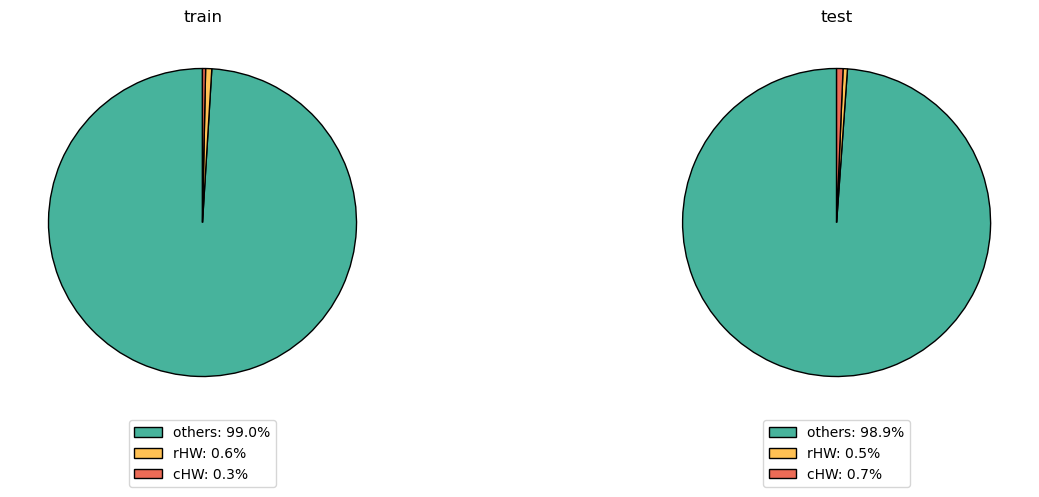

In [14]:
plot_multiple_pies([df_train, df_test], ["train","test"], num_cols=2)

In [15]:
# Sampling
X_train = df_train.iloc[:,:-2]
y_train = df_train.iloc[:,-2]

In [ ]:
# Create a SMOTEENN object
smotenn = SMOTEENN(random_state=42,n_jobs=-1)

# Apply SMOTENN to balance the dataset
X_resampled, y_resampled = smotenn.fit_resample(X_train, y_train)

logger.info(f"Class distribution after NearMiss UnderSampling: {Counter(y_resampled)}")

/home/atm/anaconda3/envs/dl23/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [ ]:
# ENN
enn = EditedNearestNeighbours(n_jobs=-1, sampling_strategy='majority')

# SMOTEENN
smotenn = SMOTEENN(enn=enn, random_state=65, n_jobs=-1)

# Apply
X_smoteenn, y_smoteenn = smotenn.fit_resample(X, y)
logger.info(f"Class distribution after SMOTEENN: {Counter(y_smoteenn)}")

In [37]:
# Initialize RobustScaler and MinMaxScaler
robust_scaler = RobustScaler()

# Split the data into training and testing sets
#X_train = robust_scaler.fit_transform(df_train.iloc[:,:-2].values)
X_train_scaled =  robust_scaler.fit_transform(X_smoteenn.values)
X_test = robust_scaler.transform(df_test.iloc[:,:-2].values)

#y_train = df_train.iloc[:,-2]
y_train_scaled = y_smoteenn
y_test = df_test.iloc[:,-2]

In [38]:
def train_random_forest(X_train, y_train, n_estimators=150, max_depth=None, random_state=None, n_jobs=12):
    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    print(class_weight_dict)
    # Initialize the Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state,
                                 class_weight=class_weight_dict, n_jobs=n_jobs)
    
    print("Training ML Classifier.")
    # Train the model
    clf.fit(X_train, y_train)
    return clf

def evaluate_model(clf, X_test, y_test):
    # Make predictions
    y_pred = clf.predict(X_test)

    # Calculate F1 score with macro averaging
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    # Generate a classification report
    classification_rep = classification_report(y_test, y_pred)

    # Generate a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return f1_macro, classification_rep, cm

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [39]:
# Train the Random Forest Classifier
clf = train_random_forest(X_train, y_train, random_state=25,n_jobs=12)

{0: 0.3362322271154661, 1: 70.96213783403657, 2: 84.93952861952862}
Training ML Classifier.


/home/atm/anaconda3/envs/dl23/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/atm/anaconda3/envs/dl23/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/atm/anaconda3/envs/dl23/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score (Macro): 0.33028166270598774
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    381510
           1       0.00      0.00      0.00      5250
           2       0.00      0.00      0.00      1800

    accuracy                           0.98    388560
   macro avg       0.33      0.33      0.33    388560
weighted avg       0.96      0.98      0.97    388560



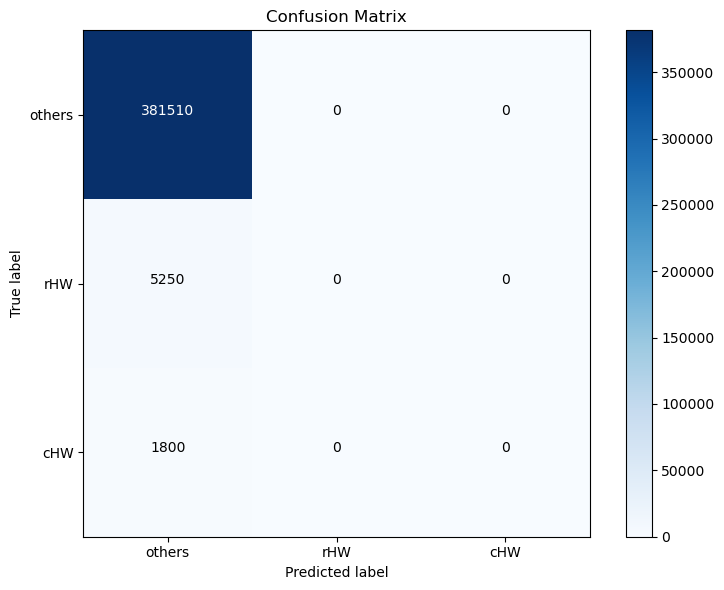

In [40]:
# Evaluate the model
f1_macro, classification_rep, cm = evaluate_model(clf, X_test, y_test)
#f1_macro, classification_rep, cm = evaluate_model(clf, X_train, y_train)

print("F1 Score (Macro):", f1_macro)
print("Classification Report:\n", classification_rep)

# Plot the confusion matrix
class_names = ["others","rHW", "cHW"]
plot_confusion_matrix(cm, classes=class_names)